# Prédiction du cours boursier

**Objectif**
- prédire le cours boursier à horizon 60 jours
- comparer les modèles

**Modèles choisis**
- ARMA
- SARIMA
- XGBoost
- Extra Trees _(variante de Random Forest)_
- Support Vector Machine (SVM)
- Prophet

**Tableau.** Modèles de prédiction

| Modèle                 | Detrend                 | Saisonnalité                  | Type             |
|:-----------------------|:------------------------|:------------------------------|:-----------------|
| ARMA                   | Moyenne mobile linéaire | Moyenne mobile linéaire       | Série temporelle |
| SARIMA                 | Moyenne mobile linéaire | Moyenne mobile linéaire       | Série temporelle |
| XGBoost                | Régression linéaire     | Mensuelle                     | Machine Learning |
| ExtraTrees             | Régression linéaire     | Mensuelle                     | Machine Learning |
| Support Vector Machine | Régression linéaire     | Mensuelle                     | Machine Learning |
| Prophet                | Pas de detrend          | Automatique                   | Autre            |

**Critères d'évaluation**
- train / test split _(test = 60 jours)_
- AIC
- MSE
- graphiquement _(la courbe ne doit pas faire "n'importe quoi")_

## Imports

In [1]:
import matplotlib.dates as mdates
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import xgboost
from prophet import Prophet
from sklearn.ensemble import ExtraTreesRegressor
from sklearn.linear_model import LinearRegression
from sklearn.svm import SVR

from src.data.load_data import load_processed_data, load_stock_data
from src.regression.models.machine_learning_detrend import detrend_prediction
from src.regression.models.sarima import sarimax
from src.regression.training.metrics import compute_metrics
from src.utils.misc import init_notebook

In [2]:
init_notebook()

In [3]:
detrend_linear_ma_window100 = "detrend/LinearMADetrend/window-100"
stock_name = "AAPL"

In [4]:
df_detrend = load_processed_data(stock_name, detrend_linear_ma_window100)

In [5]:
df_detrend.head()

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2019-01-02,-2.636750,-1.646748,-2.801751,-1.879250,-3.465916,148158800
2019-01-03,-5.465638,-5.030637,-5.960637,-5.913137,-7.341764,365248800
2019-01-04,-5.434760,-4.429759,-5.617259,-4.502261,-5.991877,234428400
2019-01-07,-4.487831,-4.455330,-5.187832,-4.680332,-6.166622,219111200
2019-01-08,-4.372408,-3.807405,-4.632406,-4.074907,-5.589533,164101200


In [6]:
prediction_results_dict = {}

# SARIMA

In [7]:
price_detrend = df_detrend["Close"]

## Train test split

In [8]:
train_test_split_date = pd.Timestamp("2021-10-01")
train, test = (
    price_detrend[price_detrend.index <= train_test_split_date],
    price_detrend[price_detrend.index > train_test_split_date],
)

In [9]:
model = sarimax(train)
result = model.fit()

C:\Users\AB2-PC\Documents\GitHub\ab2\stock-analysis\.venv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\AB2-PC\Documents\GitHub\ab2\stock-analysis\.venv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\AB2-PC\Documents\GitHub\ab2\stock-analysis\.venv\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


In [10]:
print(result.summary())

                               SARIMAX Results                                
Dep. Variable:                  Close   No. Observations:                  694
Model:             SARIMAX(10, 0, 10)   Log Likelihood               -1419.622
Date:                Sun, 12 Oct 2025   AIC                           2881.244
Time:                        15:32:22   BIC                           2976.636
Sample:                             0   HQIC                          2918.134
                                - 694                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.9855      0.111      8.856      0.000       0.767       1.204
ar.L2         -0.0222      0.089     -0.248      0.804      -0.197       0.153
ar.L3          0.0534      0.094      0.568      0.5

In [11]:
forecast_steps = len(test)
forecast = result.get_forecast(steps=forecast_steps)
predicted_values = forecast.predicted_mean

C:\Users\AB2-PC\Documents\GitHub\ab2\stock-analysis\.venv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\AB2-PC\Documents\GitHub\ab2\stock-analysis\.venv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:837: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


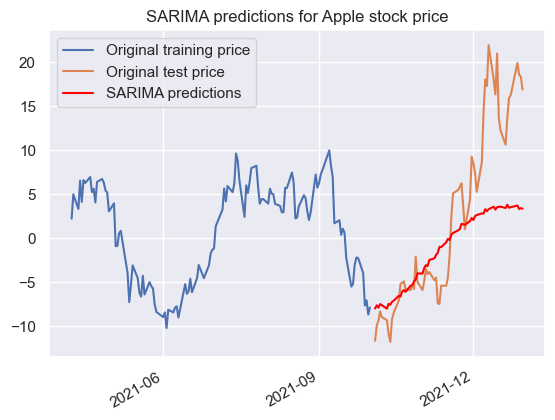

In [12]:
plot_n_days_prior_pred = 2 * forecast_steps

plt.plot(train[-plot_n_days_prior_pred:], label="Original training price")
plt.plot(test, label="Original test price")
plt.plot(test.index, predicted_values, label="SARIMA predictions", color="red")
plt.title("SARIMA predictions for Apple stock price")
plt.legend()


# Display limited number of date index
plt.gca().xaxis.set_major_locator(mdates.MonthLocator(interval=3))
# Rotate x-axis labels
plt.gcf().autofmt_xdate()

plt.show()

# Prédiction du prix d'Apple à 2 mois

Recomposons les prédictions du modèle SARIMA pour la stochasticité avec la tendance pour obtenir une prévision du cours d'Apple.

In [13]:
original_data = load_stock_data(stock_name)

In [14]:
# Get only close price
original_price = original_data["Close"]

In [15]:
# Train test split
original_data_train, original_data_test = (
    original_price[original_price.index <= train_test_split_date],
    original_price[original_price.index > train_test_split_date],
)

In [16]:
# Drop time index in order to vanish weekend days issues
original_data_train.reset_index(drop=True, inplace=True)
original_data_test.reset_index(drop=True, inplace=True)

## Tendance 

On reconstruit la tendance que l'on avait prédite par la méthode de la moyenne mobile.

In [17]:
for i in range(forecast_steps):
    rolling_mean = original_data_train.rolling(window=100, center=False).mean()
    pred_trend = rolling_mean.iloc[-1]
    pred_index = original_data_train.index[-1] + 1
    original_data_train = pd.concat(
        [original_data_train, pd.Series([pred_trend], index=[pred_index])]
    )

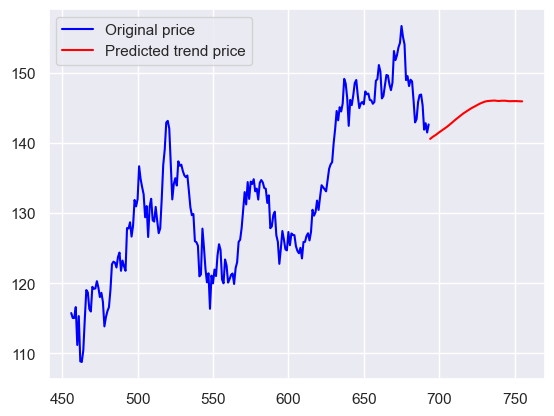

In [18]:
plt.plot(
    original_data_train.iloc[-300:-forecast_steps], color="blue", label="Original price"
)
plt.plot(
    original_data_train.iloc[-forecast_steps:],
    color="red",
    label="Predicted trend price",
)
plt.legend()

## Saisonnalité et stochasticité

In [19]:
# Make SARIMA predicted values begin at zero
predicted_values -= predicted_values.iloc[0]

In [20]:
# Calculate trend + ARIMA
add_components = original_data_train.iloc[-forecast_steps] + predicted_values

# Put predicted data in train series set
original_data_train.iloc[-forecast_steps:] = add_components

## Evaluation de la prédiction

In [21]:
# Set index for test data i.e. actual data
original_data_test.index = original_data_train.index[-forecast_steps:]

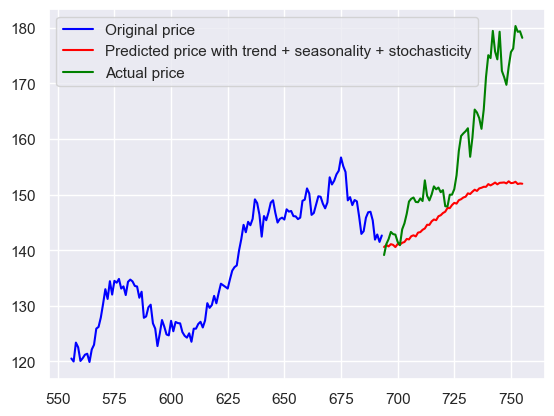

In [22]:
plt.plot(
    original_data_train.iloc[-200:-forecast_steps], color="blue", label="Original price"
)
plt.plot(
    original_data_train.iloc[-forecast_steps:],
    color="red",
    label="Predicted price with trend + seasonality + stochasticity",
)
plt.plot(original_data_test, color="green", label="Actual price")
plt.legend()

In [23]:
y_true = original_data_test
y_pred = original_data_train[-forecast_steps:]

In [24]:
prediction_results_dict["SARIMA"] = compute_metrics(y_true, y_pred)
prediction_results_dict["SARIMA"]

(10.685776472736054, 13.848887929054118)

## XGBoost

### Traitement des données

In [22]:
type(original_data)

pandas.core.frame.DataFrame

In [23]:
train_start = pd.Timestamp("2019-01-01")
train_end = pd.Timestamp("2021-10-01")

df_train = original_data.loc[train_start:train_end].copy()
df_test = original_data.loc[train_end:].copy()

In [24]:
type(df_train)
df_train["time_dummy"] = np.arange(len(df_train))
df_train

,Open,High,Low,Close,Adj Close,Volume,time_dummy
Date,,,,,,,
2019-01-02,38.722500,39.712502,38.557499,39.480000,37.943256,148158800,0
2019-01-03,35.994999,36.430000,35.500000,35.547501,34.163822,365248800,1
2019-01-04,36.132500,37.137501,35.950001,37.064999,35.622250,234428400,2
2019-01-07,37.174999,37.207500,36.474998,36.982498,35.542965,219111200,3
2019-01-08,37.389999,37.955002,37.130001,37.687500,36.220528,164101200,4
...,...,...,...,...,...,...,...
2021-09-27,145.470001,145.960007,143.820007,145.369995,143.707413,74150700,689
2021-09-28,143.250000,144.750000,141.690002,141.910004,140.286987,108972300,690
2021-09-29,142.470001,144.449997,142.029999,142.830002,141.196472,74602000,691


In [25]:
df_train["time_dummy"] = np.arange(len(df_train))
df_test["time_dummy"] = np.arange(len(df_test)) + len(df_train)
df_train["day"] = df_train.index.day
df_test["day"] = df_test.index.day

In [26]:
df_train["time_dummy"].tail()

Date
2021-09-27    689
2021-09-28    690
2021-09-29    691
2021-09-30    692
2021-10-01    693
Name: time_dummy, dtype: int64

In [27]:
df_test["time_dummy"].head()

Date
2021-10-01    694
2021-10-04    695
2021-10-05    696
2021-10-06    697
2021-10-07    698
Name: time_dummy, dtype: int64

In [28]:
x_col = ["time_dummy", "day"]
y_col = ["Close"]

In [29]:
x = df_train[x_col]
y = df_train[y_col]

In [30]:
x_test = df_test[x_col]
y_test = df_test[y_col]

### Apprentissage des modèles

In [31]:
lr = LinearRegression()

In [32]:
xgb = xgboost.XGBRegressor(random_state=0, n_jobs=-2, colsample_bytree=0.3, max_depth=3)

In [33]:
lr.fit(x, y)

,fit_intercept,True
,copy_X,True
,tol,1e-06
,n_jobs,None
,positive,False


In [34]:
y_residuals = y - lr.predict(x)
xgb.fit(x, y_residuals)

,objective,'reg:squarederror'
,base_score,None
,booster,None
,callbacks,None
,colsample_bylevel,None
,colsample_bynode,None
,colsample_bytree,0.3
,device,None
,early_stopping_rounds,None
,enable_categorical,False
,eval_metric,None


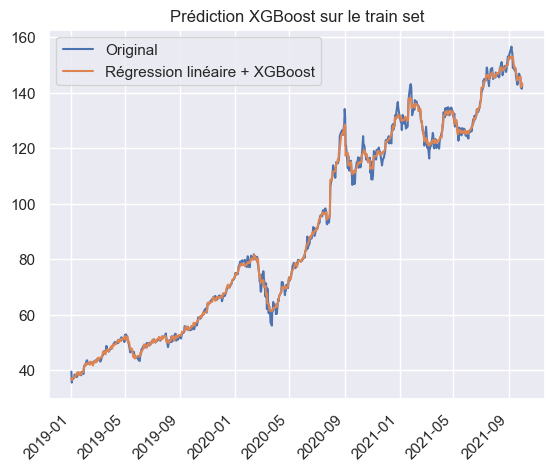

In [45]:
y_pred_train = detrend_prediction(xgb, lr, x)
y_pred_train_df = pd.DataFrame(y_pred_train)
y_pred_train_df.index = df_train.index

plt.title("Prédiction XGBoost sur le train set")
plt.plot(df_train[["Close"]], label="Original")
plt.plot(y_pred_train_df, label="Régression linéaire + XGBoost")

plt.legend()
_ = plt.xticks(rotation=45, ha="right")

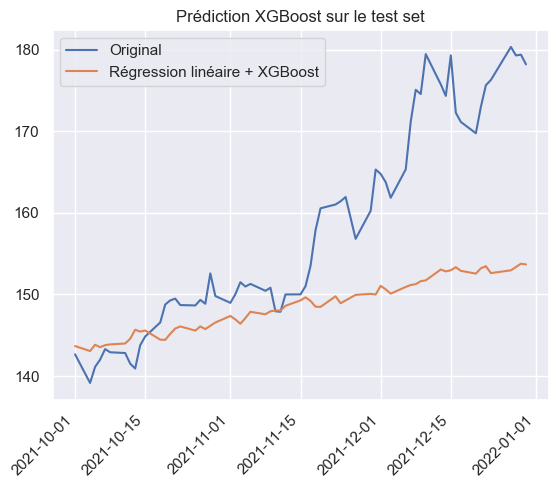

In [46]:
y_pred_test = detrend_prediction(xgb, lr, x_test)
y_pred_test_df = pd.DataFrame(y_pred_test)
y_pred_test_df.index = df_test.index

plt.title("Prédiction XGBoost sur le test set")
plt.plot(df_test[["Close"]], label="Original")
plt.plot(y_pred_test_df, label="Régression linéaire + XGBoost")

plt.legend()
_ = plt.xticks(rotation=45, ha="right")

In [37]:
y_pred = pd.DataFrame(y_pred)
y_pred.index = df_test.index

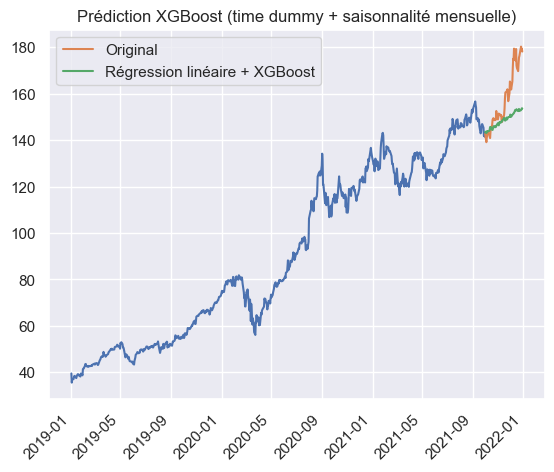

In [38]:
plt.title("Prédiction XGBoost (time dummy + saisonnalité mensuelle)")
plt.plot(df_train[["Close"]])
plt.plot(df_test[["Close"]], label="Original")
plt.plot(y_pred, label="Régression linéaire + XGBoost")
plt.legend()
_ = plt.xticks(rotation=45, ha="right")

In [39]:
prediction_results_dict["XGBoost"] = compute_metrics(y_test, y_pred)
prediction_results_dict["XGBoost"]

(9.85263703644495, 13.291437509975168)

## Extra Trees

### Apprentissage des modèles

In [68]:
lr = LinearRegression()

In [69]:
et = ExtraTreesRegressor(random_state=0, n_jobs=-2)

In [70]:
lr.fit(x, y)

,fit_intercept,True
,copy_X,True
,tol,1e-06
,n_jobs,None
,positive,False


In [71]:
y_residuals = y - lr.predict(x)
et.fit(x, y_residuals)

C:\Users\AB2-PC\Documents\GitHub\ab2\stock-analysis\.venv\Lib\site-packages\sklearn\base.py:1365: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


,n_estimators,100
,criterion,'squared_error'
,max_depth,None
,min_samples_split,2
,min_samples_leaf,1
,min_weight_fraction_leaf,0.0
,max_features,1.0
,max_leaf_nodes,None
,min_impurity_decrease,0.0
,bootstrap,False
,oob_score,False


In [73]:
y_pred = detrend_prediction(et, lr, x_test)
y_pred = pd.DataFrame(y_pred)
y_pred.index = df_test.index

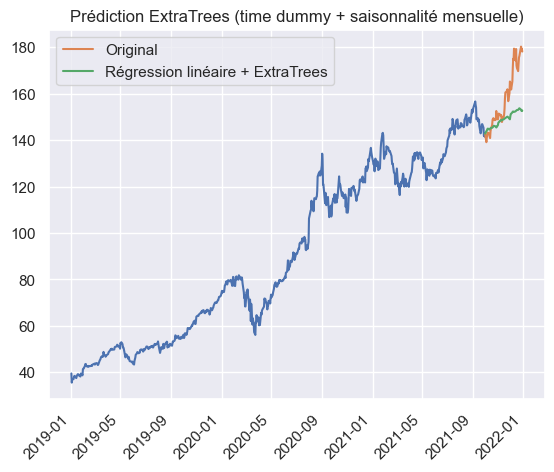

In [74]:
plt.title("Prédiction ExtraTrees (time dummy + saisonnalité mensuelle)")
plt.plot(df_train[["Close"]])
plt.plot(df_test[["Close"]], label="Original")
plt.plot(y_pred, label="Régression linéaire + ExtraTrees")
plt.legend()
_ = plt.xticks(rotation=45, ha="right")

In [75]:
prediction_results_dict["ExtraTrees"] = compute_metrics(y_test, y_pred)
prediction_results_dict["ExtraTrees"]

(9.74557499696818, 13.201822820070818)

## SVM

### Apprentissage des modèles

In [76]:
lr = LinearRegression()

In [77]:
svr = SVR()

In [78]:
lr.fit(x, y)

,fit_intercept,True
,copy_X,True
,tol,1e-06
,n_jobs,None
,positive,False


In [79]:
y_residuals = y - lr.predict(x)
svr.fit(x, y_residuals)

C:\Users\AB2-PC\Documents\GitHub\ab2\stock-analysis\.venv\Lib\site-packages\sklearn\utils\validation.py:1406: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


,kernel,'rbf'
,degree,3
,gamma,'scale'
,coef0,0.0
,tol,0.001
,C,1.0
,epsilon,0.1
,shrinking,True
,cache_size,200
,verbose,False
,max_iter,-1


In [81]:
y_pred = detrend_prediction(svr, lr, x_test)
y_pred = pd.DataFrame(y_pred)
y_pred.index = df_test.index

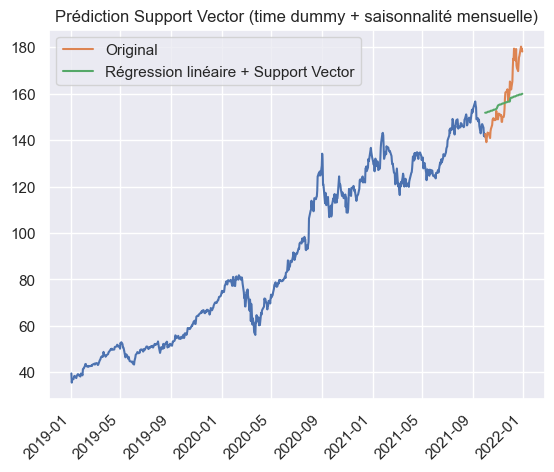

In [82]:
plt.title("Prédiction Support Vector (time dummy + saisonnalité mensuelle)")
plt.plot(df_train[["Close"]])
plt.plot(df_test[["Close"]], label="Original")
plt.plot(y_pred, label="Régression linéaire + Support Vector")
plt.legend()
_ = plt.xticks(rotation=45, ha="right")

In [83]:
prediction_results_dict["Support Vector Machine"] = compute_metrics(y_test, y_pred)
prediction_results_dict["Support Vector Machine"]

(8.73950426028892, 10.297525832287155)

## Prophet

### Pré-traitement pour Prophet

In [84]:
df = original_data

In [85]:
df_train = df.loc[train_start_date:train_end_date]

NameError: name 'train_start_date' is not defined

In [83]:
df_train.shape

(694, 6)

In [84]:
x = df_train[[]].copy()

In [85]:
x["ds"] = df_train.index
x["y"] = df_train[["Close"]]

In [86]:
x.head()

,ds,y
Date,,
2019-01-02,2019-01-02,39.480000
2019-01-03,2019-01-03,35.547501
2019-01-04,2019-01-04,37.064999
2019-01-07,2019-01-07,36.982498
2019-01-08,2019-01-08,37.687500


### Prédiction

#### Calcul de la prédiction

In [87]:
model = Prophet()
model.fit(x)

18:56:23 - cmdstanpy - INFO - Chain [1] start processing
18:56:23 - cmdstanpy - INFO - Chain [1] done processing


In [88]:
future = x_test.copy()
future["ds"] = x_test.index

In [89]:
forecast = model.predict(future)
forecast[["ds", "yhat", "yhat_lower", "yhat_upper"]].tail()

,ds,yhat,yhat_lower,yhat_upper
58,2021-12-23,164.084319,158.023536,170.512306
59,2021-12-27,165.483298,159.009757,171.977113
60,2021-12-28,165.809740,159.002697,172.418749
61,2021-12-29,166.157137,159.850301,172.330433
62,2021-12-30,166.183145,159.808016,173.400756


#### Affichage de la prédiction

C:\Users\AB2-PC\Documents\GitHub\ab2\stock-analysis\.venv\Lib\site-packages\pandas\plotting\_matplotlib\core.py:981: UserWarning: This axis already has a converter set and is updating to a potentially incompatible converter
  return ax.plot(*args, **kwds)


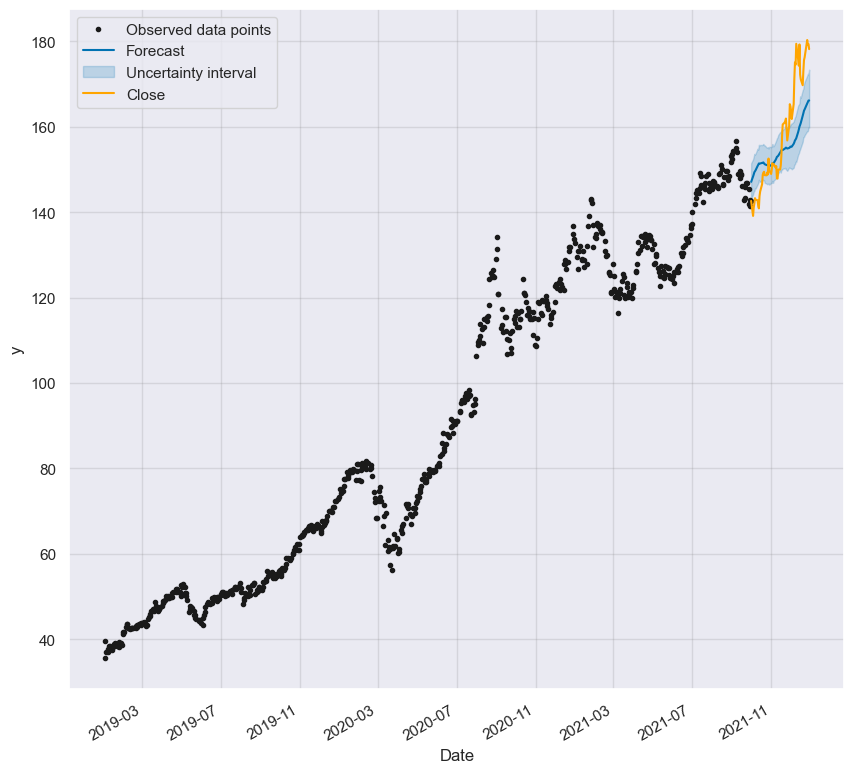

In [90]:
fig, ax1 = plt.subplots(figsize=(10, 10))
fig1 = model.plot(forecast, ax=ax1)
df[["Close"]].loc[train_end_date:].plot(ax=ax1, color="orange")
plt.legend()

### Décomposition

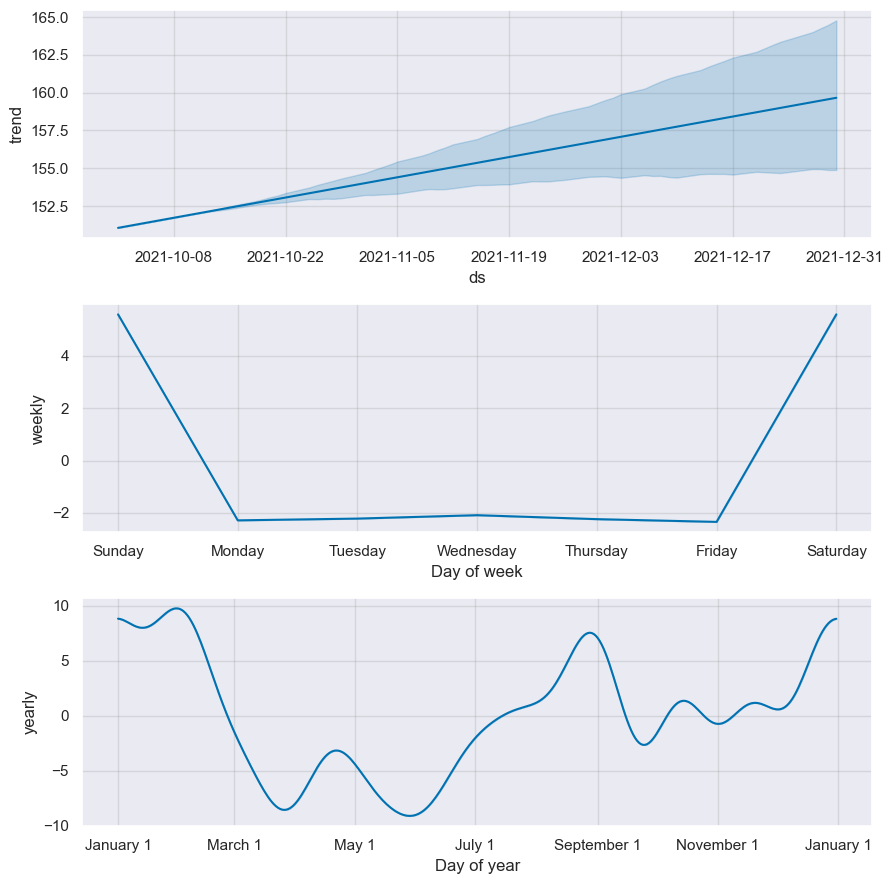

In [91]:
fig2 = model.plot_components(forecast)

### Métriques de prédiction

In [92]:
y_true = df[["Close"]].loc[train_end_date:]
y_pred = forecast[["yhat"]].iloc[-y_true.shape[0] :]

In [94]:
prediction_results_dict["Prophet"] = compute_metrics(y_test, y_pred)
prediction_results_dict["Prophet"]

RMSE: 8.971550821832377
MAE: 7.262063933618879


## Comparaison des modèles

In [96]:
prediction_results_df = pd.DataFrame(prediction_results_dict).T
prediction_results_df.columns = ["RMSE", "MAE"]
# prediction_results_df

(array([0, 1, 2, 3, 4]),
 [Text(0, 0, 'SARIMA'),
  Text(1, 0, 'XGBoost'),
  Text(2, 0, 'ExtraTrees'),
  Text(3, 0, 'Support Vector Machine'),
  Text(4, 0, 'Prophet')])

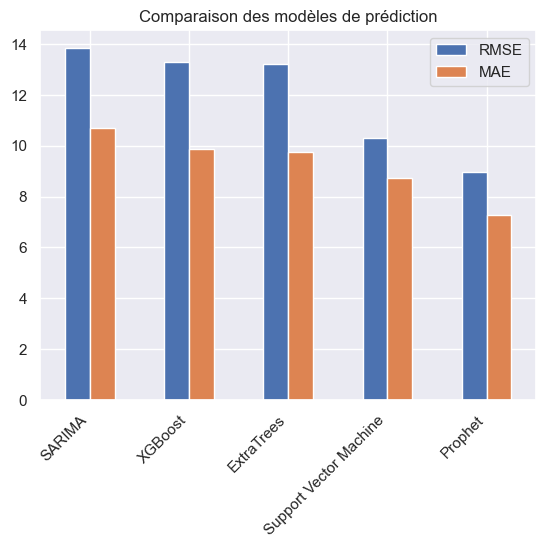

In [97]:
prediction_results_df.plot(kind="bar")
plt.title("Comparaison des modèles de prédiction")

plt.xticks(rotation=45, ha="right")

In [98]:
# print(prediction_results_df.to_markdown())

**Tableau.** Comparaison des modèles de prédiction

|                        |        RMSE |         MAE | Graphiquement |
|:-----------------------|------------:|------------:|:-------------:|
| ARMA                   |     17.3524 |     14.9797 |       ✅       |
| SARIMA                 |     13.6817 |     11.6047 |       ✅       |
| XGBoost                |     13.2914 |     9.85264 |       ✅       |
| ExtraTrees             |     13.2018 |     9.74557 |       ✅       |
| Support Vector Machine |     10.2975 |      8.7395 |       ❌       |
| **Prophet**            | **8.97155** | **7.26206** |       ✅       |

Meilleur modèle : Prophet